# One-shot multi-step LSTM Model on Lab p4679
Author: Camilla Billari <br> 
Date: 06/02/24

Fitting a one-shot multi-step LSTM to the lab p4679 dataset.

In [44]:
# Import relevant libraries
import matplotlib.pyplot as plt

# Import local modules - note: dependent on above path being set.
from utils.dataset import SlowEarthquakeDataset
from utils.nn_io import load_model, save_model
from utils.general_functions import set_seed, set_torch_device
from utils.data_preprocessing import moving_average_causal_filter, compare_feature_statistics, create_dataset, split_train_test_forecast_windows, normalise_dataset
from utils.plotting import plot_original_vs_processed_data, plot_example_sample, plot_metric_results, plot_all_data_results
from utils.nn_train import train_model
import scripts.lstm_oneshot_multistep as lstm

Camillas-MacBook-Pro-2.local


In [2]:
# Set random seed
SEED = 17 # random seed for the dataset and model
set_seed(SEED)

# Set torch device
device = set_torch_device()

No GPU available.


## Load Data

In [3]:
EXP = "p4679" # select Marone p4679 experiment

# Load dataset and convert to dataframe
dataset = SlowEarthquakeDataset([EXP])
df = SlowEarthquakeDataset.convert_to_df(dataset, EXP)

df.head()

,obs_shear_stress,obs_normal_stress,obs_ecdisp,time
0,5.091520,6.986740,22107.1104,0.000
1,5.090652,6.988410,22109.7823,0.001
2,5.089989,6.986299,22103.7900,0.002
3,5.089492,6.985970,22109.2161,0.003
4,5.088243,6.987547,22108.5900,0.004


In [5]:
# Select segment average and scale down by 10^8
shear_stress_df = df["obs_shear_stress"]

shear_stress_df.shape

(301721,)

## Data Pre-processing

### Denoising

In [6]:
# Data smoothing
SMOOTHING_WINDOW = 1 # moving average window size
DOWNSAMPLING_FACTOR = 50

# Smooth the data
df_smoothed = moving_average_causal_filter(shear_stress_df, SMOOTHING_WINDOW, DOWNSAMPLING_FACTOR)

df_smoothed.shape

(6034,)

In [7]:
# Check if smoothed results are statistically significantly different
results = compare_feature_statistics(shear_stress_df, df_smoothed)
print(results)

{'mean_comparison': {'t_statistic': -0.02370466572558935, 'p_value': 0.9810881997104777, 'significant': False}, 'variance_comparison': {'f_statistic': 0.0005619111772409071, 'p_value': 0.9810881993193293, 'significant': False}}


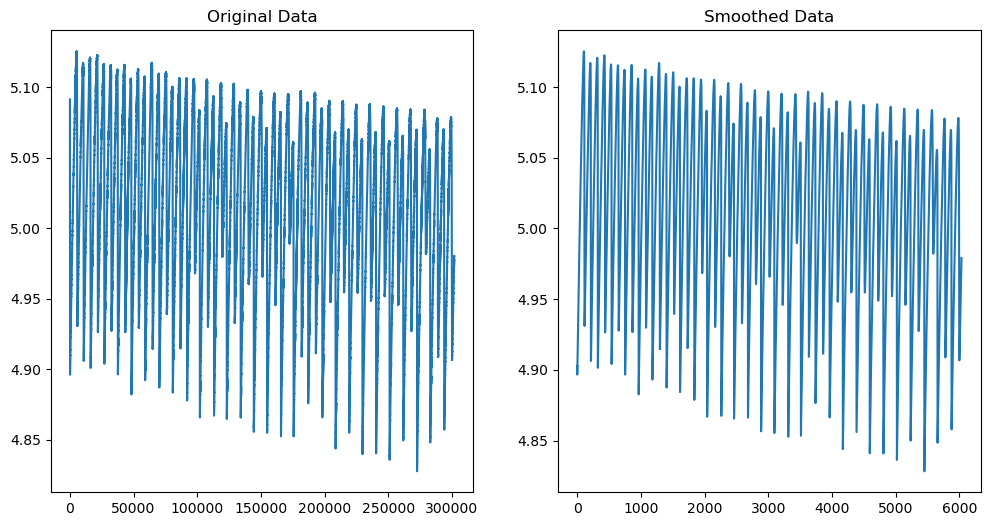

In [8]:
plot_original_vs_processed_data(shear_stress_df, df_smoothed, "line")

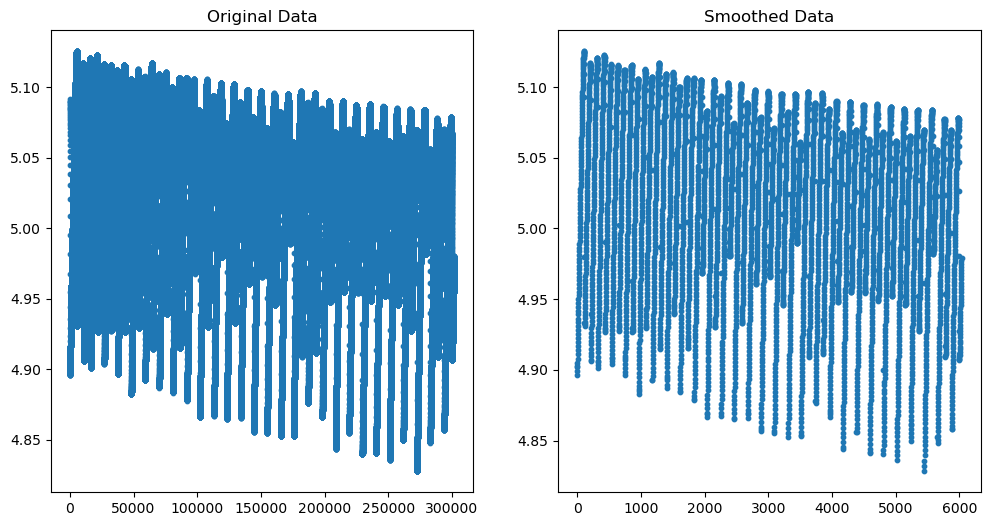

In [9]:
plot_original_vs_processed_data(shear_stress_df, df_smoothed, "scatter")

## Creating the datastet

In [10]:
# Dataset parameters
LOOKBACK, FORECAST = 80, 14 # lookback and forecast values
N_FORECAST_WINDOWS = 40 # n forecasted windows in test set

# Pre-process the data into windows
X, y = create_dataset(df_smoothed, LOOKBACK, FORECAST)

print(f"X and y shapes: {X.shape}, {y.shape}")

X and y shapes: torch.Size([5941, 80]), torch.Size([5941, 14])


In [11]:
# Split into train and test sets and normalise it
X_train, y_train, X_test, y_test = split_train_test_forecast_windows(X, y, FORECAST, N_FORECAST_WINDOWS)

# Display shapes of the created datasets
print(f"Training data shapes: {X_train.shape}, {y_train.shape}")
print(f"Testing data shapes: {X_test.shape}, {y_test.shape}")

Training data shapes: torch.Size([5376, 80]), torch.Size([5376, 14])
Testing data shapes: torch.Size([560, 80]), torch.Size([560, 14])


### Normalising with scaler based on the training set

In [12]:
# Normalise the dataset and save all sets into data_dict; keep scalers for later.
data_dict, scaler_X, scaler_y = normalise_dataset(X_train, y_train, X_test, y_test)

print(data_dict.keys())

dict_keys(['X_train', 'y_train', 'X_test', 'y_test', 'X_train_sc', 'y_train_sc', 'X_test_sc', 'y_test_sc'])


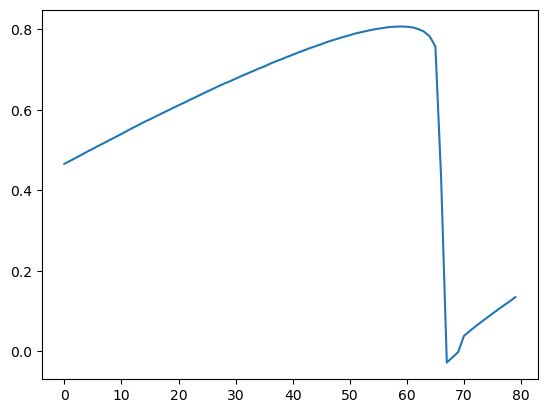

In [13]:
# Plot 3rd X_test window
plt.plot(data_dict["X_test_sc"][2, :])

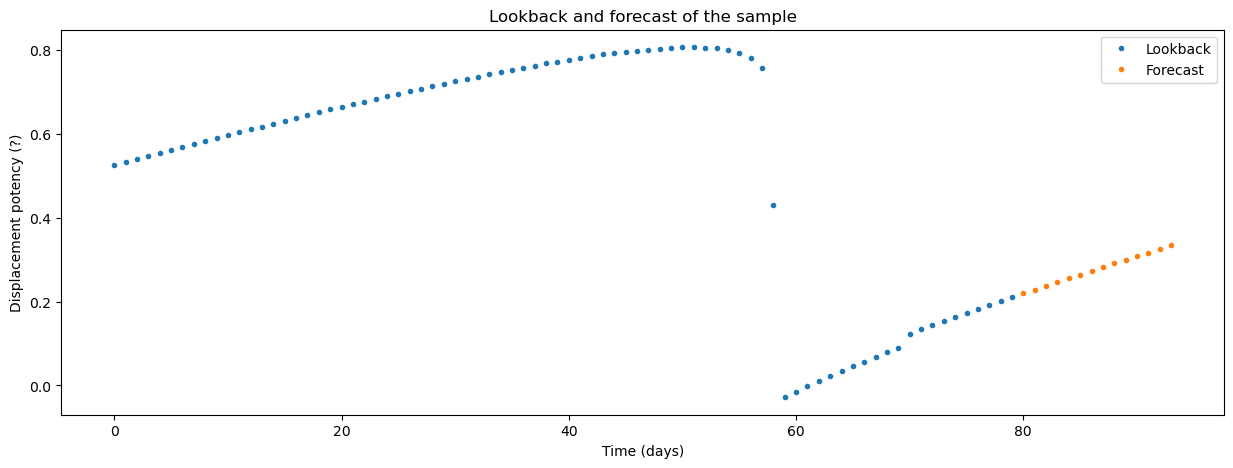

In [15]:
plot_example_sample(data_dict["X_test_sc"], data_dict["y_test_sc"], 10, LOOKBACK, FORECAST)

## Modelling

In [17]:
# For LSTM config
N_VARIATES = 1
HIDDEN_SIZE = 50
N_LAYERS = 1
OUTPUT_SIZE = FORECAST

model = lstm.MultiStepLstmSingleLayer(N_VARIATES, HIDDEN_SIZE, N_LAYERS, OUTPUT_SIZE, device).to(device)

### Training

In [18]:
# For LSTM training
N_EPOCHS = 75
results_dict = train_model(model, N_EPOCHS, data_dict, scaler_y, device)

  0%|          | 0/75 [00:00<?, ?it/s]

Epoch [75/75], Train RMSE: 0.0211, Test RMSE: 0.0235, Train R2: 0.8969, Test R2: 0.8552, Last Batch Loss: 0.0046: 100%|██████████| 75/75 [10:54<00:00,  8.72s/it]


## Results

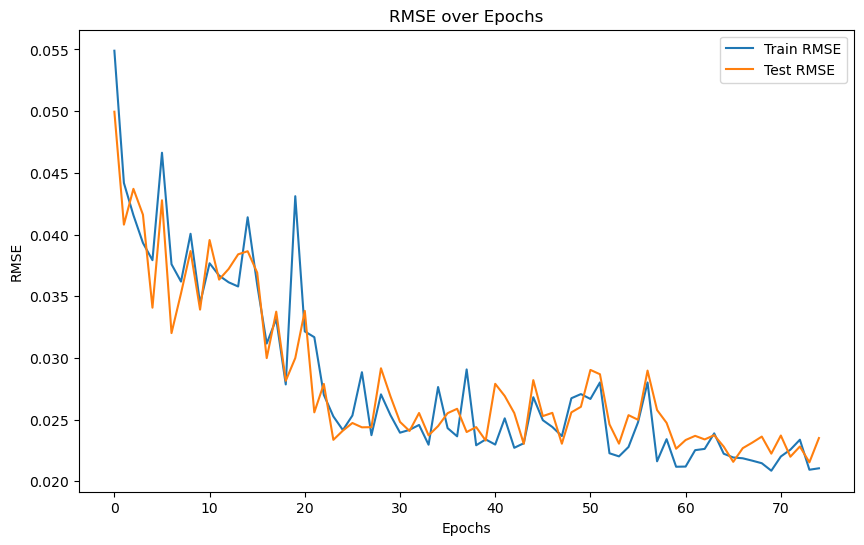

In [24]:
# Plot RMSE
plot_metric_results(N_EPOCHS, results_dict["train_rmse_list"], results_dict["test_rmse_list"], "RMSE")

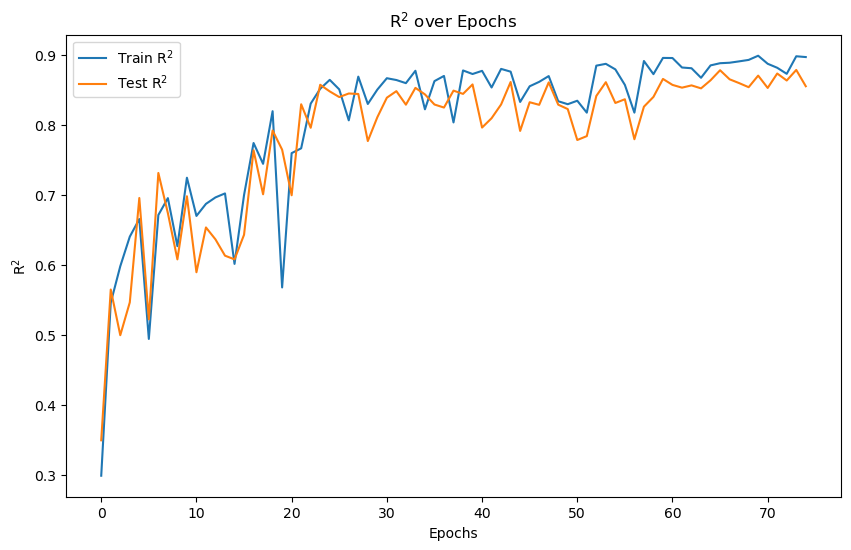

In [25]:
# Plot R2
plot_metric_results(N_EPOCHS, results_dict["train_r2_list"], results_dict["test_r2_list"], "R$^2$")

In [26]:
# Plot predictions against true values
TEST_START_IDX = len(df_smoothed) - len(y_test)
TITLE = "Original Time Series and Model Predictions of Segment 1 sum"
X_LABEL = "Time (days)"
Y_LABEL = "Displacement potency (?)"
ZOOM_MIN = 2600
ZOOM_MAX = 2800
ZOOM_WINDOW = [ZOOM_MIN, ZOOM_MAX]

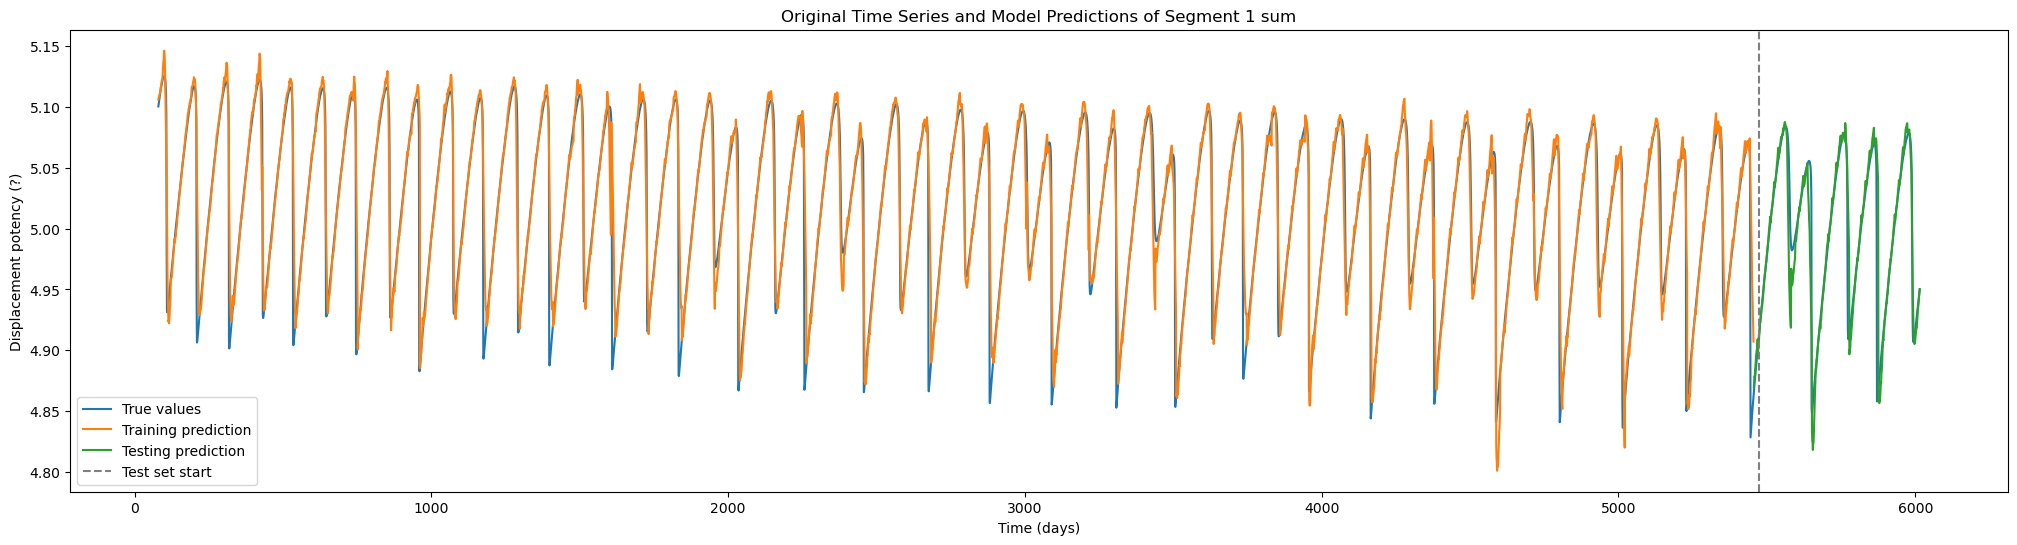

In [27]:
plot_all_data_results(TEST_START_IDX, data_dict, results_dict, LOOKBACK, FORECAST, TITLE, X_LABEL, Y_LABEL, [])


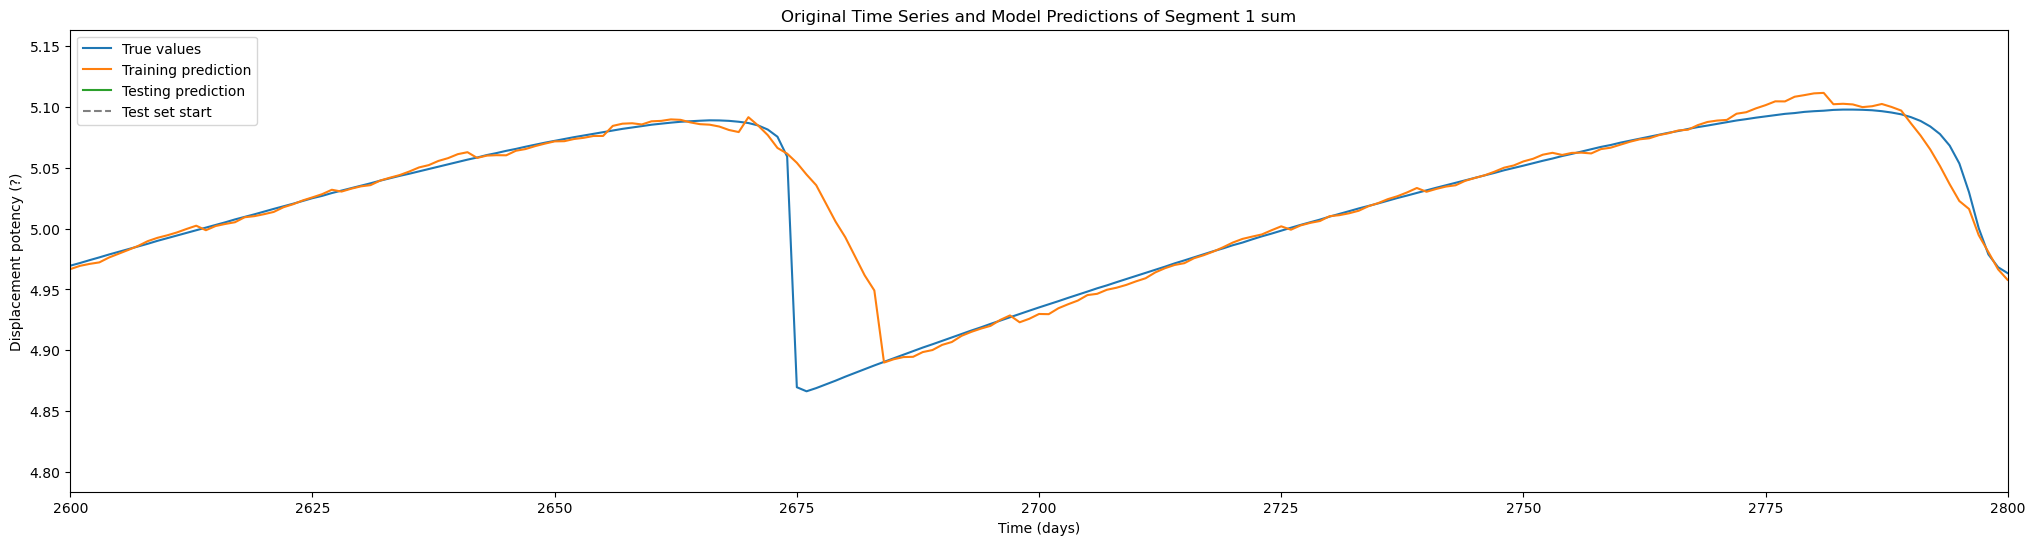

In [28]:
plot_all_data_results(TEST_START_IDX, data_dict, results_dict, LOOKBACK, FORECAST, TITLE, X_LABEL, Y_LABEL, ZOOM_WINDOW)
# LOOK AT BOKE

## Pritt's LSTM

In [29]:
# For LSTM config
N_VARIATES = 1
HIDDEN_SIZE = 50
N_LAYERS = 1
OUTPUT_SIZE = FORECAST
model_multi_layer = lstm.MultiStepLstmMultiLayer(N_VARIATES, HIDDEN_SIZE, N_LAYERS, OUTPUT_SIZE, device).to(device)

In [30]:
# For LSTM training
N_EPOCHS = 75
results_dict_multi_layer = train_model(model_multi_layer, N_EPOCHS, data_dict, scaler_y, device)

Epoch [75/75], Train RMSE: 0.0191, Test RMSE: 0.0205, Train R2: 0.9148, Test R2: 0.8903, Last Batch Loss: 0.0039: 100%|██████████| 75/75 [09:37<00:00,  7.69s/it]


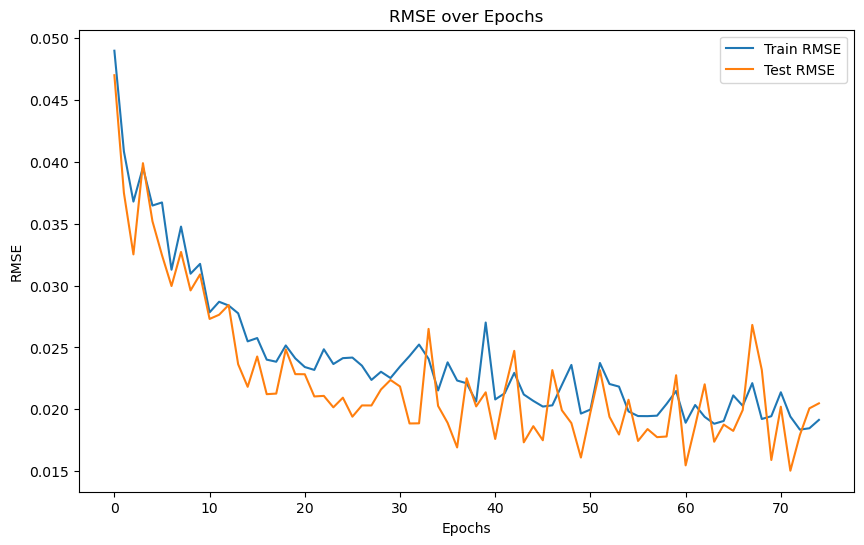

In [31]:
# Plot RMSE
plot_metric_results(N_EPOCHS, results_dict_multi_layer["train_rmse_list"], results_dict_multi_layer["test_rmse_list"], "RMSE")

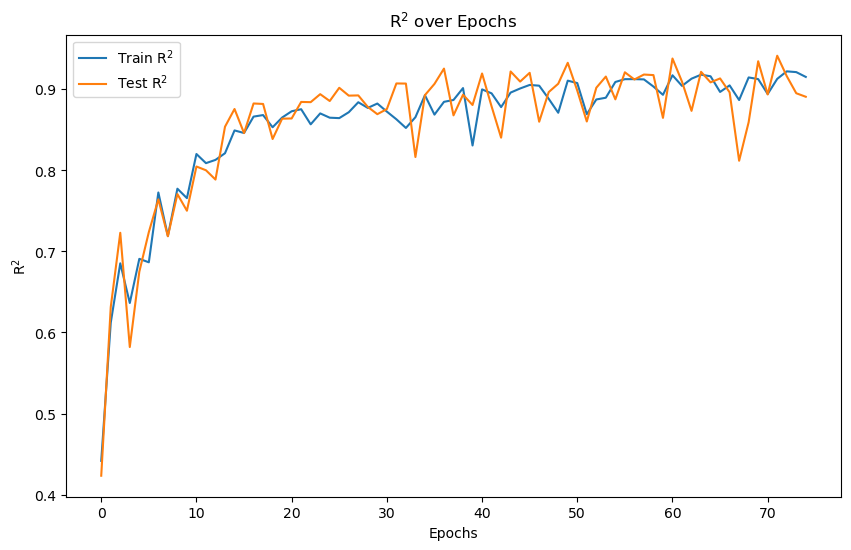

In [32]:
# Plot R2
plot_metric_results(N_EPOCHS, results_dict_multi_layer["train_r2_list"], results_dict_multi_layer["test_r2_list"], "R$^2$")

In [33]:
# Plot predictions against true values
TEST_START_IDX = len(df_smoothed) - len(y_test)
TITLE = "Original Time Series and Model Predictions of Segment 1 sum"
X_LABEL = "Time (days)"
Y_LABEL = "Displacement potency (?)"
ZOOM_MIN = 2600
ZOOM_MAX = 2800
ZOOM_WINDOW = [ZOOM_MIN, ZOOM_MAX]

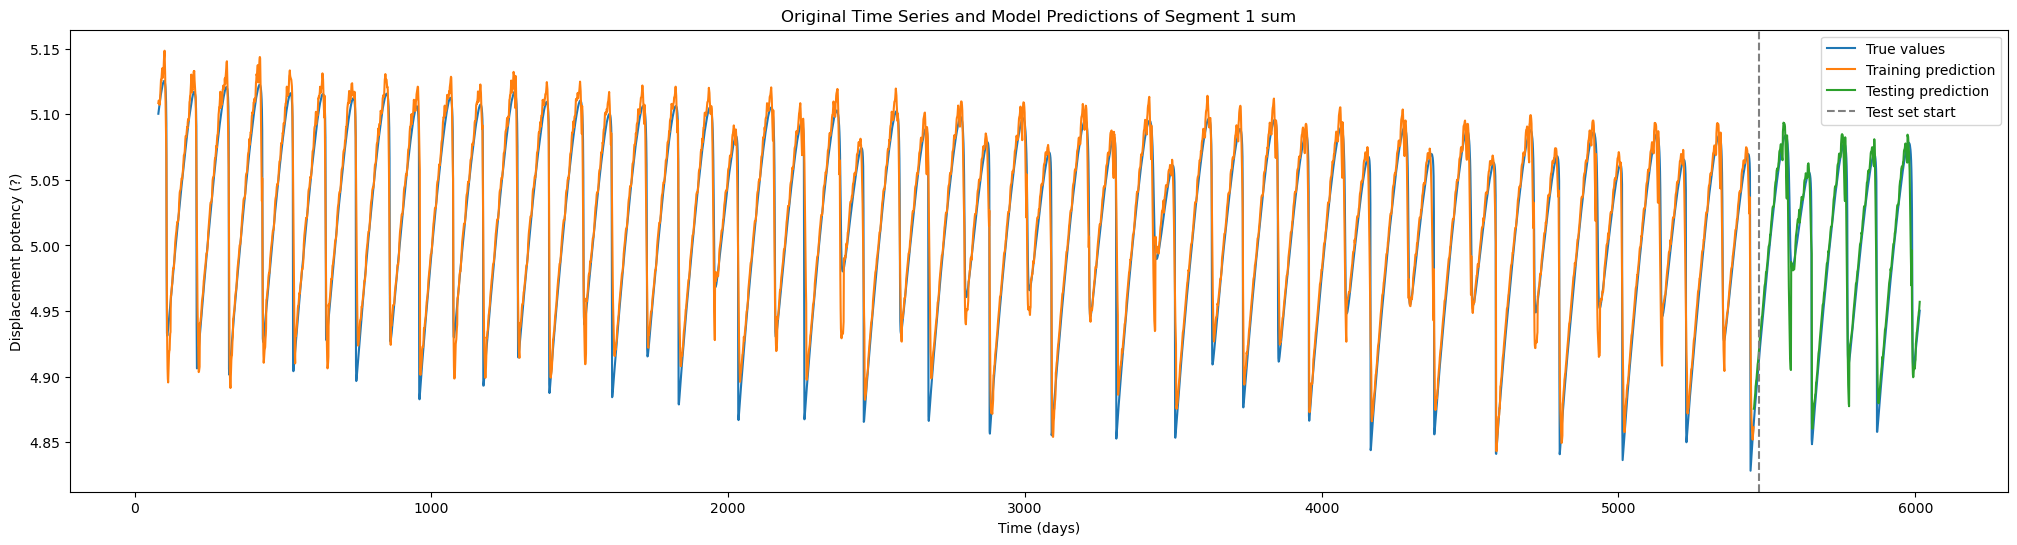

In [34]:
plot_all_data_results(TEST_START_IDX, data_dict, results_dict_multi_layer, LOOKBACK, FORECAST, TITLE, X_LABEL, Y_LABEL, [])

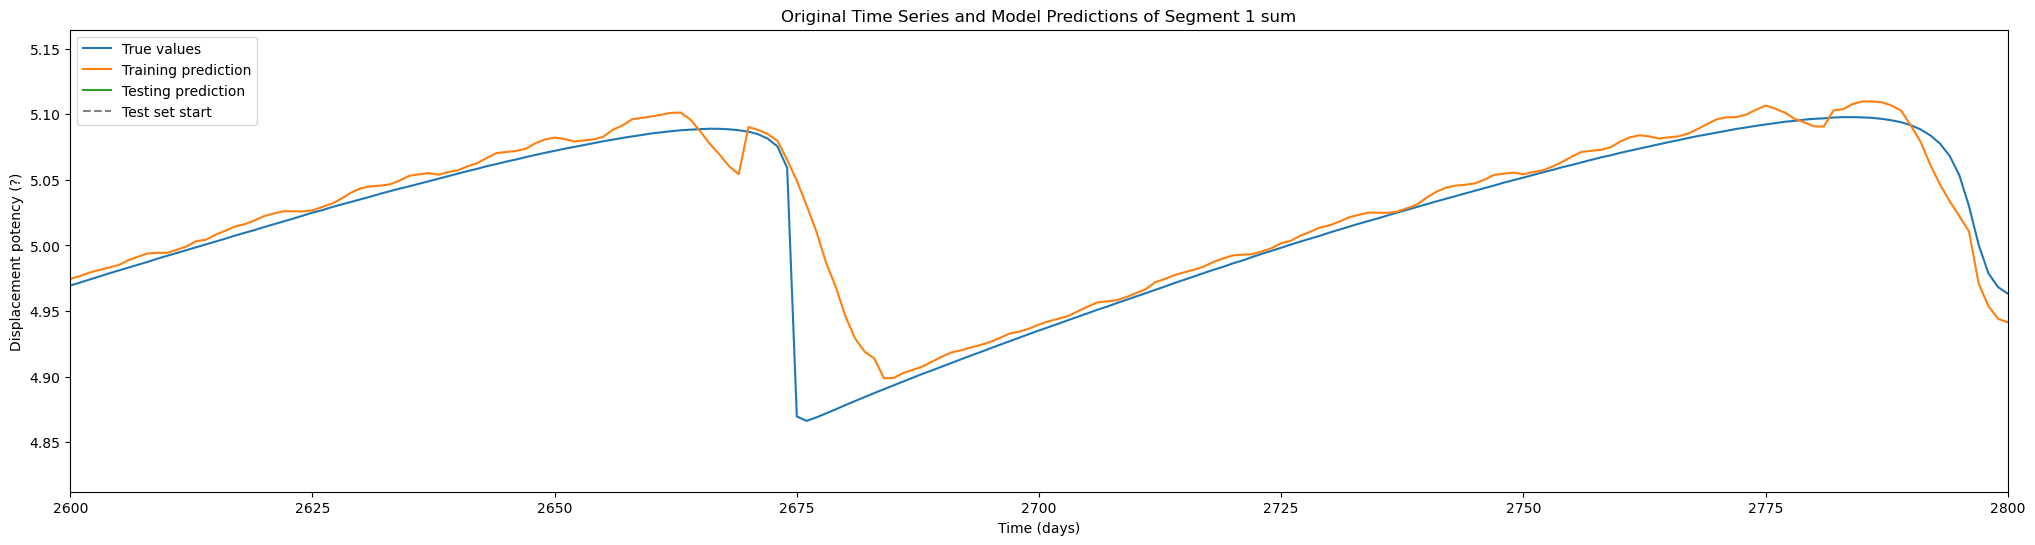

In [35]:
plot_all_data_results(TEST_START_IDX, data_dict, results_dict_multi_layer, LOOKBACK, FORECAST, TITLE, X_LABEL, Y_LABEL, ZOOM_WINDOW)

In [ ]:
# # Ask Pritt why he does it like this
# save_model(
#     model,
#     ts_data[TS_COLUMN].values,
#     pred=all_outputs,
#     pred_index=range(LOOKBACK, LOOKBACK + len(all_outputs)),
# )